In [1]:
# import numpy, pandas, seaborn, matplotlib just because
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import pickle

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot

from datetime import datetime

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Time series forecasting on Biden vs Trump polling

In [2]:
# reading in the polling data from Economist.com
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ56fySJKLL18Lipu1_i3ID9JE06voJEz2EXm6JW4Vh11zmndyTwejMavuNntzIWLY0RyhA1UsVEen0/pub?gid=0&single=true&output=csv')
df = df.sort_values(by=['end.date'], ascending=True)
df = df.reset_index()
del df['index']

# creating dataframes for each battleground state
df_az = df.loc[df['state'] == 'AZ']
df_fl = df.loc[df['state'] == 'FL']
df_ga = df.loc[df['state'] == 'GA']
df_ia = df.loc[df['state'] == 'IA']
df_mi = df.loc[df['state'] == 'MI']
df_nv = df.loc[df['state'] == 'NV']
df_nh = df.loc[df['state'] == 'NH']
df_nc = df.loc[df['state'] == 'NC']
df_oh = df.loc[df['state'] == 'OH']
df_pa = df.loc[df['state'] == 'PA']
df_tx = df.loc[df['state'] == 'TX']
df_wi = df.loc[df['state'] == 'WI']

### Change the state in the next cell block to determine the state being forecasted in the remainder of the notebook

In [3]:
poll = df_nh # <- change state here

In [4]:
poll = poll.sort_values(by=['end.date'], ascending=True)
poll = poll.reset_index()
del poll['index']

In [5]:
poll_og = poll.copy()

In [6]:
# coordinating the titles for the slides later
if poll_og['state'][0] == 'AZ':
    state = 'Arizona'
if poll_og['state'][0] == 'FL':
    state = 'Florida'
if poll_og['state'][0] == 'GA':
    state = 'Georgia'
if poll_og['state'][0] == 'IA':
    state = 'Iowa'
if poll_og['state'][0] == 'MI':
    state = 'Michigan'
if poll_og['state'][0] == 'NV':
    state = 'Nevada'
if poll_og['state'][0] == 'NH':
    state = 'New Hampshire'
if poll_og['state'][0] == 'NC':
    state = 'North Carolina'
if poll_og['state'][0] == 'OH':
    state = 'Ohio'
if poll_og['state'][0] == 'PA':
    state = 'Pennsylvania'
if poll_og['state'][0] == 'TX':
    state = 'Texas'
if poll_og['state'][0] == 'WI':
    state = 'Wisconsin'

now = datetime.now()
current_date = now.strftime("%m/%d/%Y")

In [7]:
poll.drop(['state', 'pollster', 'sponsor', 'start.date', 'entry.date.time..et.', 'number.of.observations', 'population', 'mode', 'biden', 'trump', 'other', 'undecided', 'url', 'include', 'note'], axis=1, inplace=True)
poll = poll.rename(columns = {'end.date':'ds'})
poll = poll.rename(columns = {'biden_margin':'y'})

## Cleaning for outliers and adding caps if necessary

In [8]:
poll.shape

(9, 2)

In [9]:
# previewing data
poll.head()

,ds,y
0,2/10/2020,-2.4
1,2/25/2020,-2.0
2,4/27/2020,8.0
3,5/18/2020,-2.0
4,6/16/2020,7.0


In [10]:
# Removing outliers 
poll.drop([8], inplace=True)

# reset index
poll = poll.reset_index()
del poll['index']

In [11]:
# checking for outliers again
poll.head()

,ds,y
0,2/10/2020,-2.4
1,2/25/2020,-2.0
2,4/27/2020,8.0
3,5/18/2020,-2.0
4,6/16/2020,7.0


In [12]:
# adding cap and floor to current
# change this in respect to each state's data
poll['cap']= 13
poll['floor'] = -5

In [13]:
poll.head()

,ds,y,cap,floor
0,2/10/2020,-2.4,13,-5
1,2/25/2020,-2.0,13,-5
2,4/27/2020,8.0,13,-5
3,5/18/2020,-2.0,13,-5
4,6/16/2020,7.0,13,-5


# Modeling

In [14]:
# model = Prophet()
model = Prophet(growth='logistic') # must specify cap and floor in data to use logistic
model.fit(poll)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


In [15]:
poll.tail()

,ds,y,cap,floor
3,5/18/2020,-2.0,13,-5
4,6/16/2020,7.0,13,-5
5,6/22/2020,13.0,13,-5
6,7/28/2020,13.0,13,-5
7,8/17/2020,8.0,13,-5


### Adjust periods below for the forecast to end at 11/3

In [16]:
future = model.make_future_dataframe(periods=78)

# adding cap and floor to future
# change this in respect to each state's data
future['cap'] = 13
future['floor'] = -5

In [17]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
81,2020-10-30,12.676804,7.596142,17.147525
82,2020-10-31,12.685349,7.927094,17.571816
83,2020-11-01,12.693737,7.714460,17.554057
84,2020-11-02,11.870897,7.182065,16.907671
85,2020-11-03,12.634332,7.704114,17.550015


In [18]:
forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-10,-1.667693,13,-5,-7.386649,2.491883,-1.667693,-1.667693,-0.701531,-0.701531,-0.701531,-0.701531,-0.701531,-0.701531,0.0,0.0,0.0,-2.369224
1,2020-02-25,-0.797685,13,-5,-5.558864,4.025291,-0.797685,-0.797685,0.053822,0.053822,0.053822,0.053822,0.053822,0.053822,0.0,0.0,0.0,-0.743863
2,2020-04-27,4.102084,13,-5,-1.133262,8.276149,4.102084,4.102084,-0.701531,-0.701531,-0.701531,-0.701531,-0.701531,-0.701531,0.0,0.0,0.0,3.400553
3,2020-05-18,5.918833,13,-5,0.274735,10.263679,5.918833,5.918833,-0.701531,-0.701531,-0.701531,-0.701531,-0.701531,-0.701531,0.0,0.0,0.0,5.217302
4,2020-06-16,8.158148,13,-5,3.475823,12.982495,8.158148,8.158148,0.053822,0.053822,0.053822,0.053822,0.053822,0.053822,0.0,0.0,0.0,8.211970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,2020-10-30,12.547263,13,-5,7.596142,17.147525,12.547263,12.547263,0.129542,0.129542,0.129542,0.129542,0.129542,0.129542,0.0,0.0,0.0,12.676804
82,2020-10-31,12.555807,13,-5,7.927094,17.571816,12.555807,12.555807,0.129542,0.129542,0.129542,0.129542,0.129542,0.129542,0.0,0.0,0.0,12.685349
83,2020-11-01,12.564195,13,-5,7.714460,17.554057,12.564195,12.564195,0.129542,0.129542,0.129542,0.129542,0.129542,0.129542,0.0,0.0,0.0,12.693737
84,2020-11-02,12.572428,13,-5,7.182065,16.907671,12.572428,12.572428,-0.701531,-0.701531,-0.701531,-0.701531,-0.701531,-0.701531,0.0,0.0,0.0,11.870897


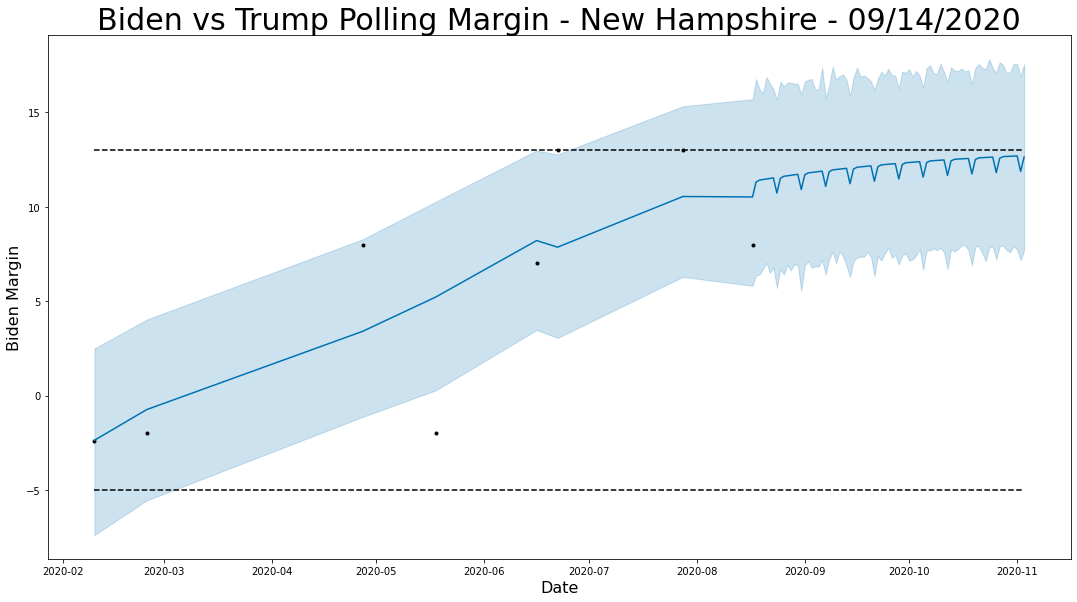

In [19]:
fig1 = model.plot(forecast, figsize=(15,8))
plt.title('Biden vs Trump Polling Margin' + ' - ' + state + ' - ' + current_date, fontsize = 30)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Biden Margin', fontsize = 16)
plt.grid(b=None)

In [20]:
index = forecast.index
last_row = len(index) - 1
print("In " + state + ", Joe Biden's predicted margin over Donald Trump on election day is " + str(round(forecast['trend'][last_row],2)) + '%')

In New Hampshire, Joe Biden's predicted margin over Donald Trump on election day is 12.58%


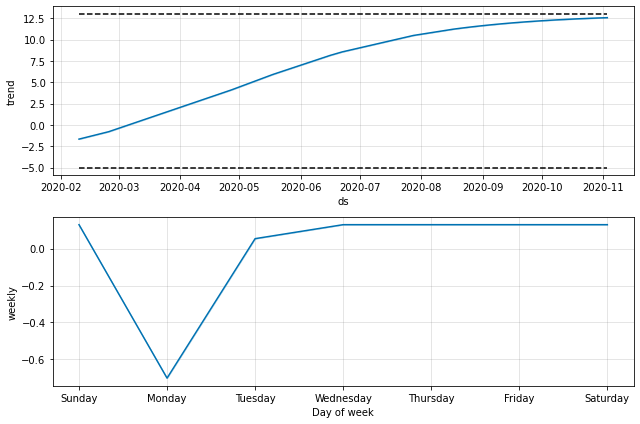

In [21]:
fig2 = model.plot_components(forecast)

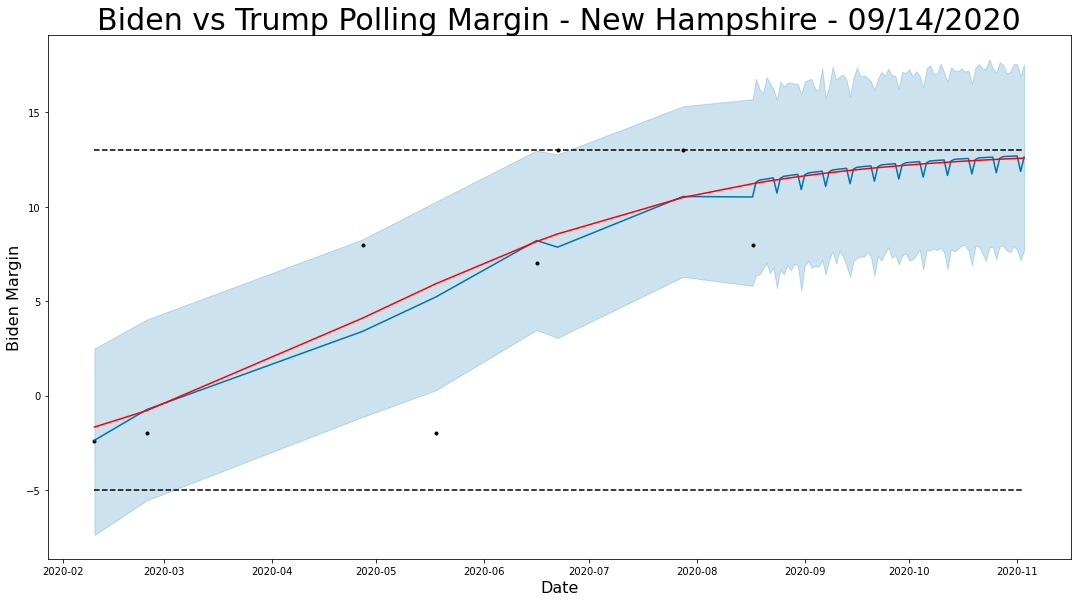

In [22]:
fig = model.plot(forecast, figsize=(15, 8))
a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.title('Biden vs Trump Polling Margin' + ' - ' + state + ' - ' + current_date, fontsize = 30)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Biden Margin', fontsize = 16)
plt.grid(b=None)